In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
import pandas as pd
import string
from scipy.stats import mode
import xarray as xr

In [2]:
### Load data
f_gt = Path('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/sandia_scripts/OSSE_Spinners/spinner_recon_ensemble.nc')
ds_gt = xr.open_dataset(f_gt)
ds_gt1 = ds_gt.isel(ens=0)
ds_gt2 = ds_gt.isel(ens=1)
ds_gt3 = ds_gt.isel(ens=2)

## Reconstructions
parent_dir_mod = Path('/projects/wakedynamics/orybchuk/bcs-ldm/analyze/inflow_validation/sandia_scripts')
f_mod1 = Path(parent_dir_mod, '1500', 'spinner_recon_ensemble.nc')
f_mod2 = Path(parent_dir_mod, '1530', 'spinner_recon_ensemble.nc')
f_mod3 = Path(parent_dir_mod, '1600', 'spinner_recon_ensemble.nc')
ds_mod1 = xr.open_dataset(f_mod1)
ds_mod2 = xr.open_dataset(f_mod2)
ds_mod3 = xr.open_dataset(f_mod3)

flag_flip_recon_inflow = False
if flag_flip_recon_inflow:
    print("Vals before")
    print(ds_mod1['vlos'].isel(ens=0, time=0, z=8).values)
    ds_mod1['vlos'].data = np.flip(ds_mod1['vlos'].data, axis=1)
    print("Vals after")
    print(ds_mod1['vlos'].isel(ens=0, time=0, z=8).values)
    ds_mod2['vlos'].data = np.flip(ds_mod2['vlos'].data, axis=1)
    ds_mod3['vlos'].data = np.flip(ds_mod3['vlos'].data, axis=1)

## Halo data
parent_dir_halo = Path('/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/osse/processed_amrwind_obs')
f_halo1 = Path(parent_dir_halo, 'y3840/long-upsampled-inflow-3D.nc')
f_halo2 = Path(parent_dir_halo, 'y7680/long-upsampled-inflow-3D.nc')
f_halo3 = Path(parent_dir_halo, 'y11520/long-upsampled-inflow-3D.nc')
ds_halo1 = xr.open_dataset(f_halo1)
ds_halo2 = xr.open_dataset(f_halo2)
ds_halo3 = xr.open_dataset(f_halo3)

In [3]:
### Sync up in time
## There are two shifts:
## - The reconstructions start at 1970-01-01T03:32:41.000000000
## - I want to take the last 600 seconds of the reconstructed winds
# Sync up to the reconstructed winds
first_timestamp_of_recon = pd.Timestamp("1970-01-01T03:32:45.000000000")  # See Issue #84 in bcs-ldm for the calculation, and then round to 5 sec resolution
n_time_first_match = 141  # The number of timesteps that we will analyze
shift_due_to_10_min_trim = len(ds_mod1['time']) - n_time_first_match
dt_gt = ds_gt1['time'].values[1] - ds_gt1['time'].values[0]

time_mod_raw = pd.date_range(first_timestamp_of_recon,
              first_timestamp_of_recon + dt_gt*(len(ds_mod1['time'])-1),
              freq='5 s')
ds_mod1['time'] = time_mod_raw.copy()
ds_mod2['time'] = time_mod_raw.copy()
ds_mod3['time'] = time_mod_raw.copy()

# Lidar shifting # TODO

# GT shifting
ds_gt1 = ds_gt1.sel(time=slice(ds_mod1['time'].min(), ds_mod1['time'].max()))
ds_gt2 = ds_gt2.sel(time=slice(ds_mod1['time'].min(), ds_mod1['time'].max()))
ds_gt3 = ds_gt3.sel(time=slice(ds_mod1['time'].min(), ds_mod1['time'].max()))

## Trim down to 600 seconds
ds_mod1 = ds_mod1.isel(time=slice(20,140))
ds_mod2 = ds_mod2.isel(time=slice(20,140))
ds_mod3 = ds_mod3.isel(time=slice(20,140))

ds_gt1 = ds_gt1.isel(time=slice(20,140))
ds_gt2 = ds_gt2.isel(time=slice(20,140))
ds_gt3 = ds_gt3.isel(time=slice(20,140))

# Qualitative

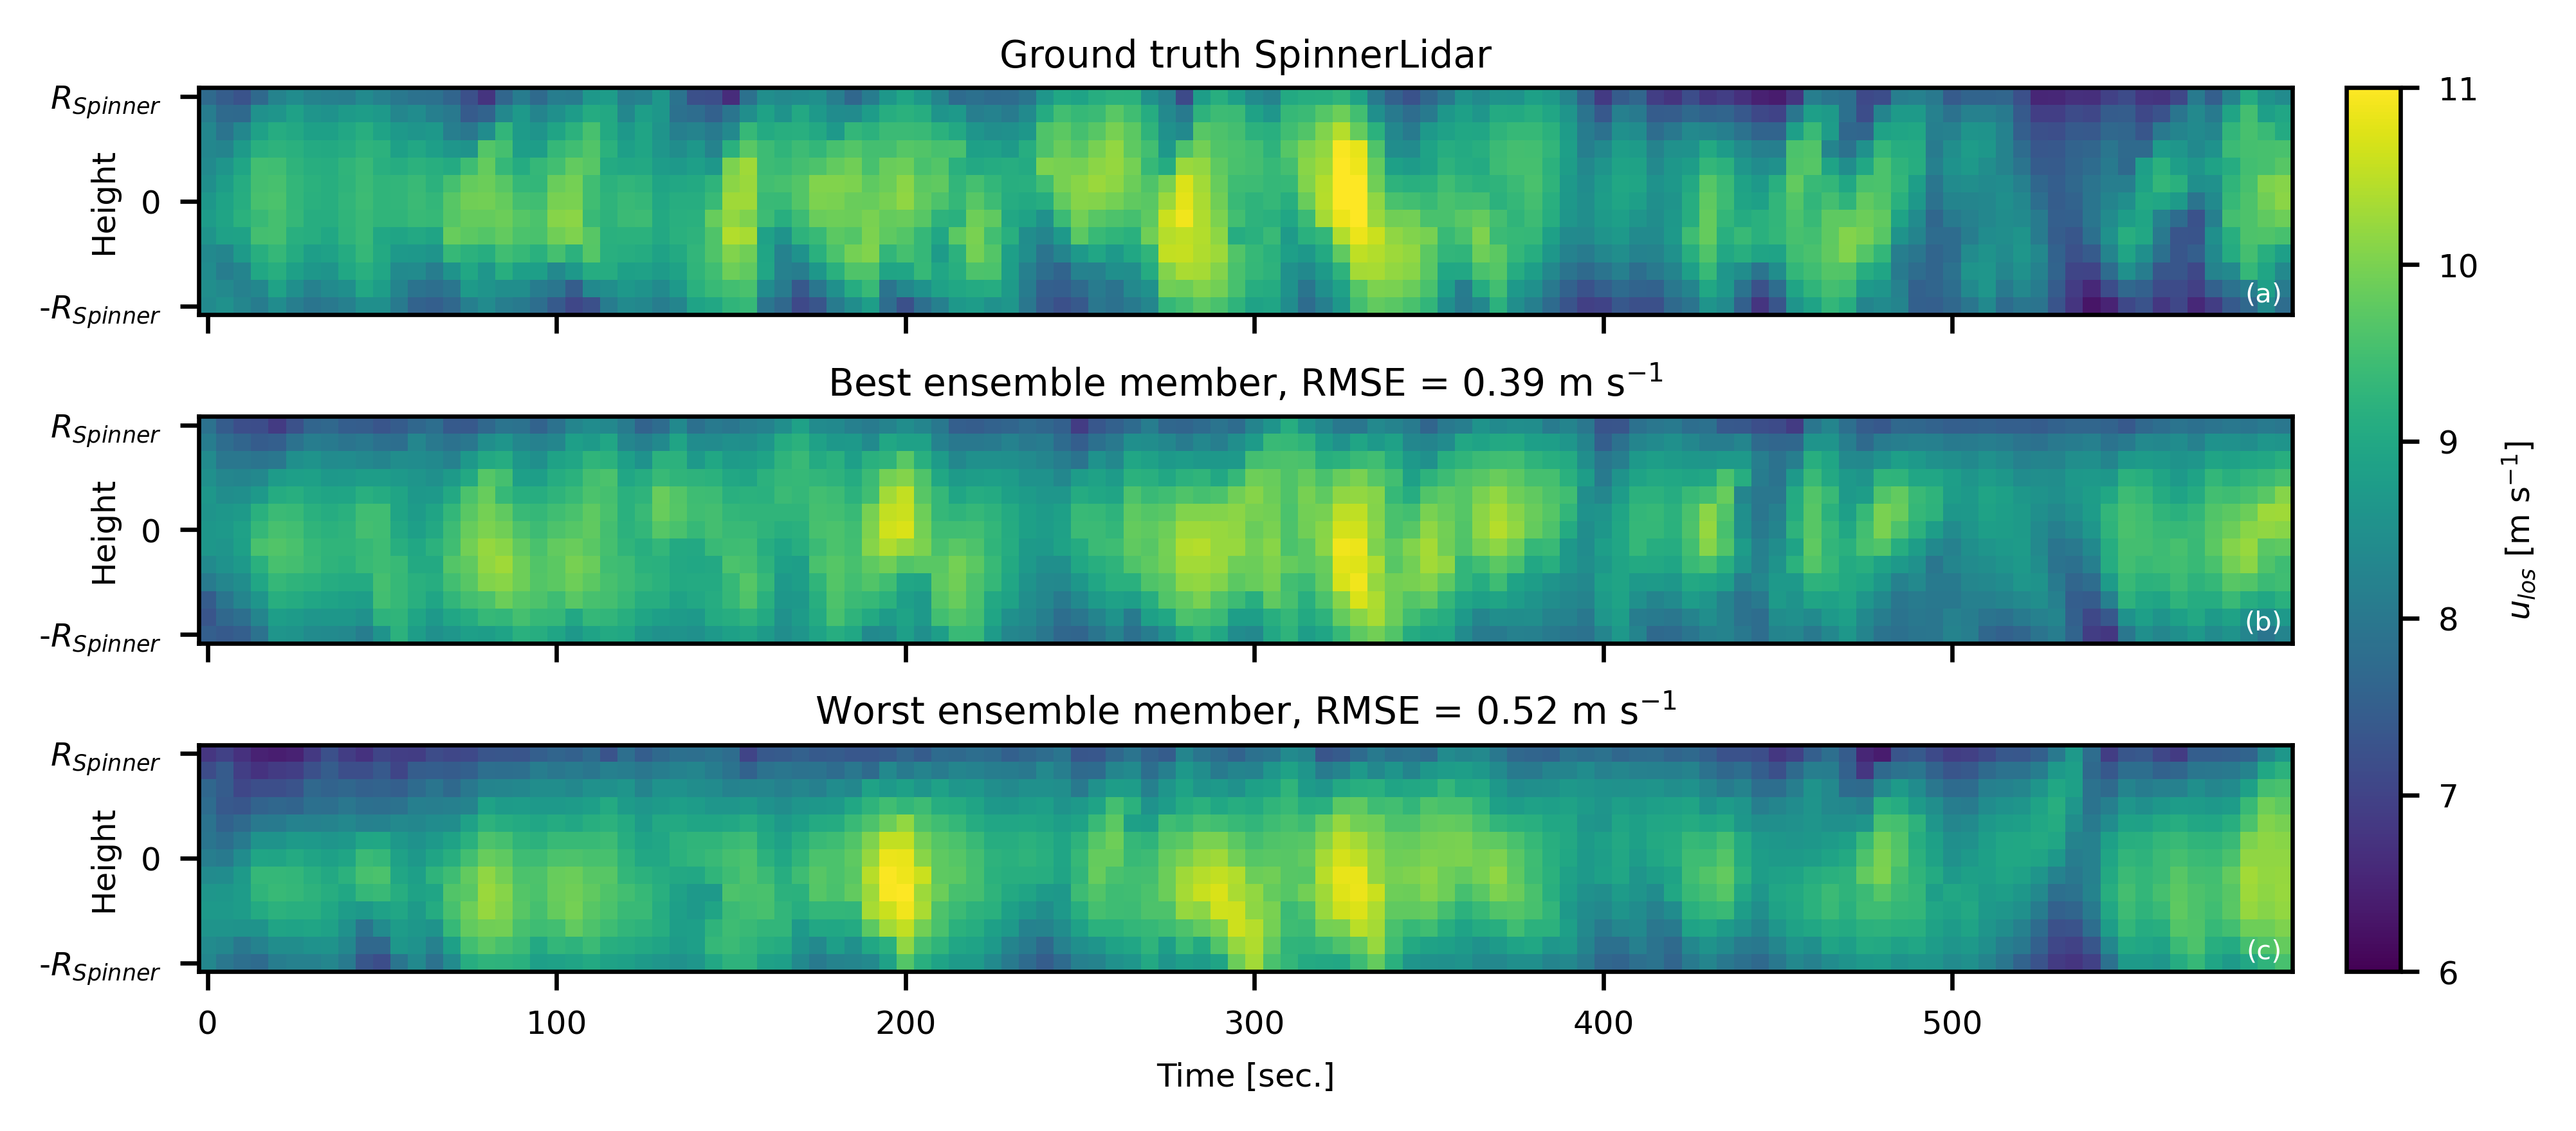

In [4]:
### Side views
fig, ax = plt.subplots(3, 1, figsize=(7,3), dpi=600, sharex=True)

case_id = 'OSSE3 Period'
ds_halo = ds_halo3
ds_gt = ds_gt3
ds_mod = ds_mod3

## Plot
pltvar = 'vlos'
pltmin, pltmax = 6, 11
yplt = 0
zplt = ds_gt['z'].values[1:14]
plt.subplots_adjust(hspace=0.4)

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_mod[pltvar] - ds_gt[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)
# iens_best = 0
# iens_worst = 1

data0 = ds_gt[pltvar].sel(y=yplt,z=zplt).values.T
data1 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_best).values.T
data2 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_worst).values.T

im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)


## Decorate
ax[0].set_title(f"Ground truth SpinnerLidar",fontsize=7,y=0.95)
ax[1].set_title(f"Best ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[2].set_title(f"Worst ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[-1].set_xlabel("Time [sec.]",fontsize=6)

for axs in ax:
    yticks = np.array((0, 6, 12))
    axs.set_yticks(yticks)
    axs.set_yticklabels(['-$R_{Spinner}$', '0', '$R_{Spinner}$'])
    axs.set_ylabel("Height",fontsize=6,labelpad=-15)
    axs.tick_params('both',labelsize=6)
xticks = np.arange(0,120,20)
ax[-1].set_xticks(xticks)
ax[-1].set_xticklabels(5*xticks)

## Colorbar
# cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
#                      ax[0].get_position().y0,
#                      0.02,
#                      ax[0].get_position().y1-ax[0].get_position().y0])
# cbar0 = fig.colorbar(im0, cax=cax0)
# cbar0.set_label('$u$ [m s$^{-1}$]', fontsize=6)
# cbar0.ax.tick_params(labelsize=6)

cax1 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('$u_{los}$ [m s$^{-1}$]', fontsize=6)
cbar1.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.059,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('figs/spinner_qualitative_side_view.png', bbox_inches='tight', dpi=600)
# plt.savefig('figs/spinner_qualitative_side_view_osse1.png', bbox_inches='tight', dpi=600)
    
plt.show()

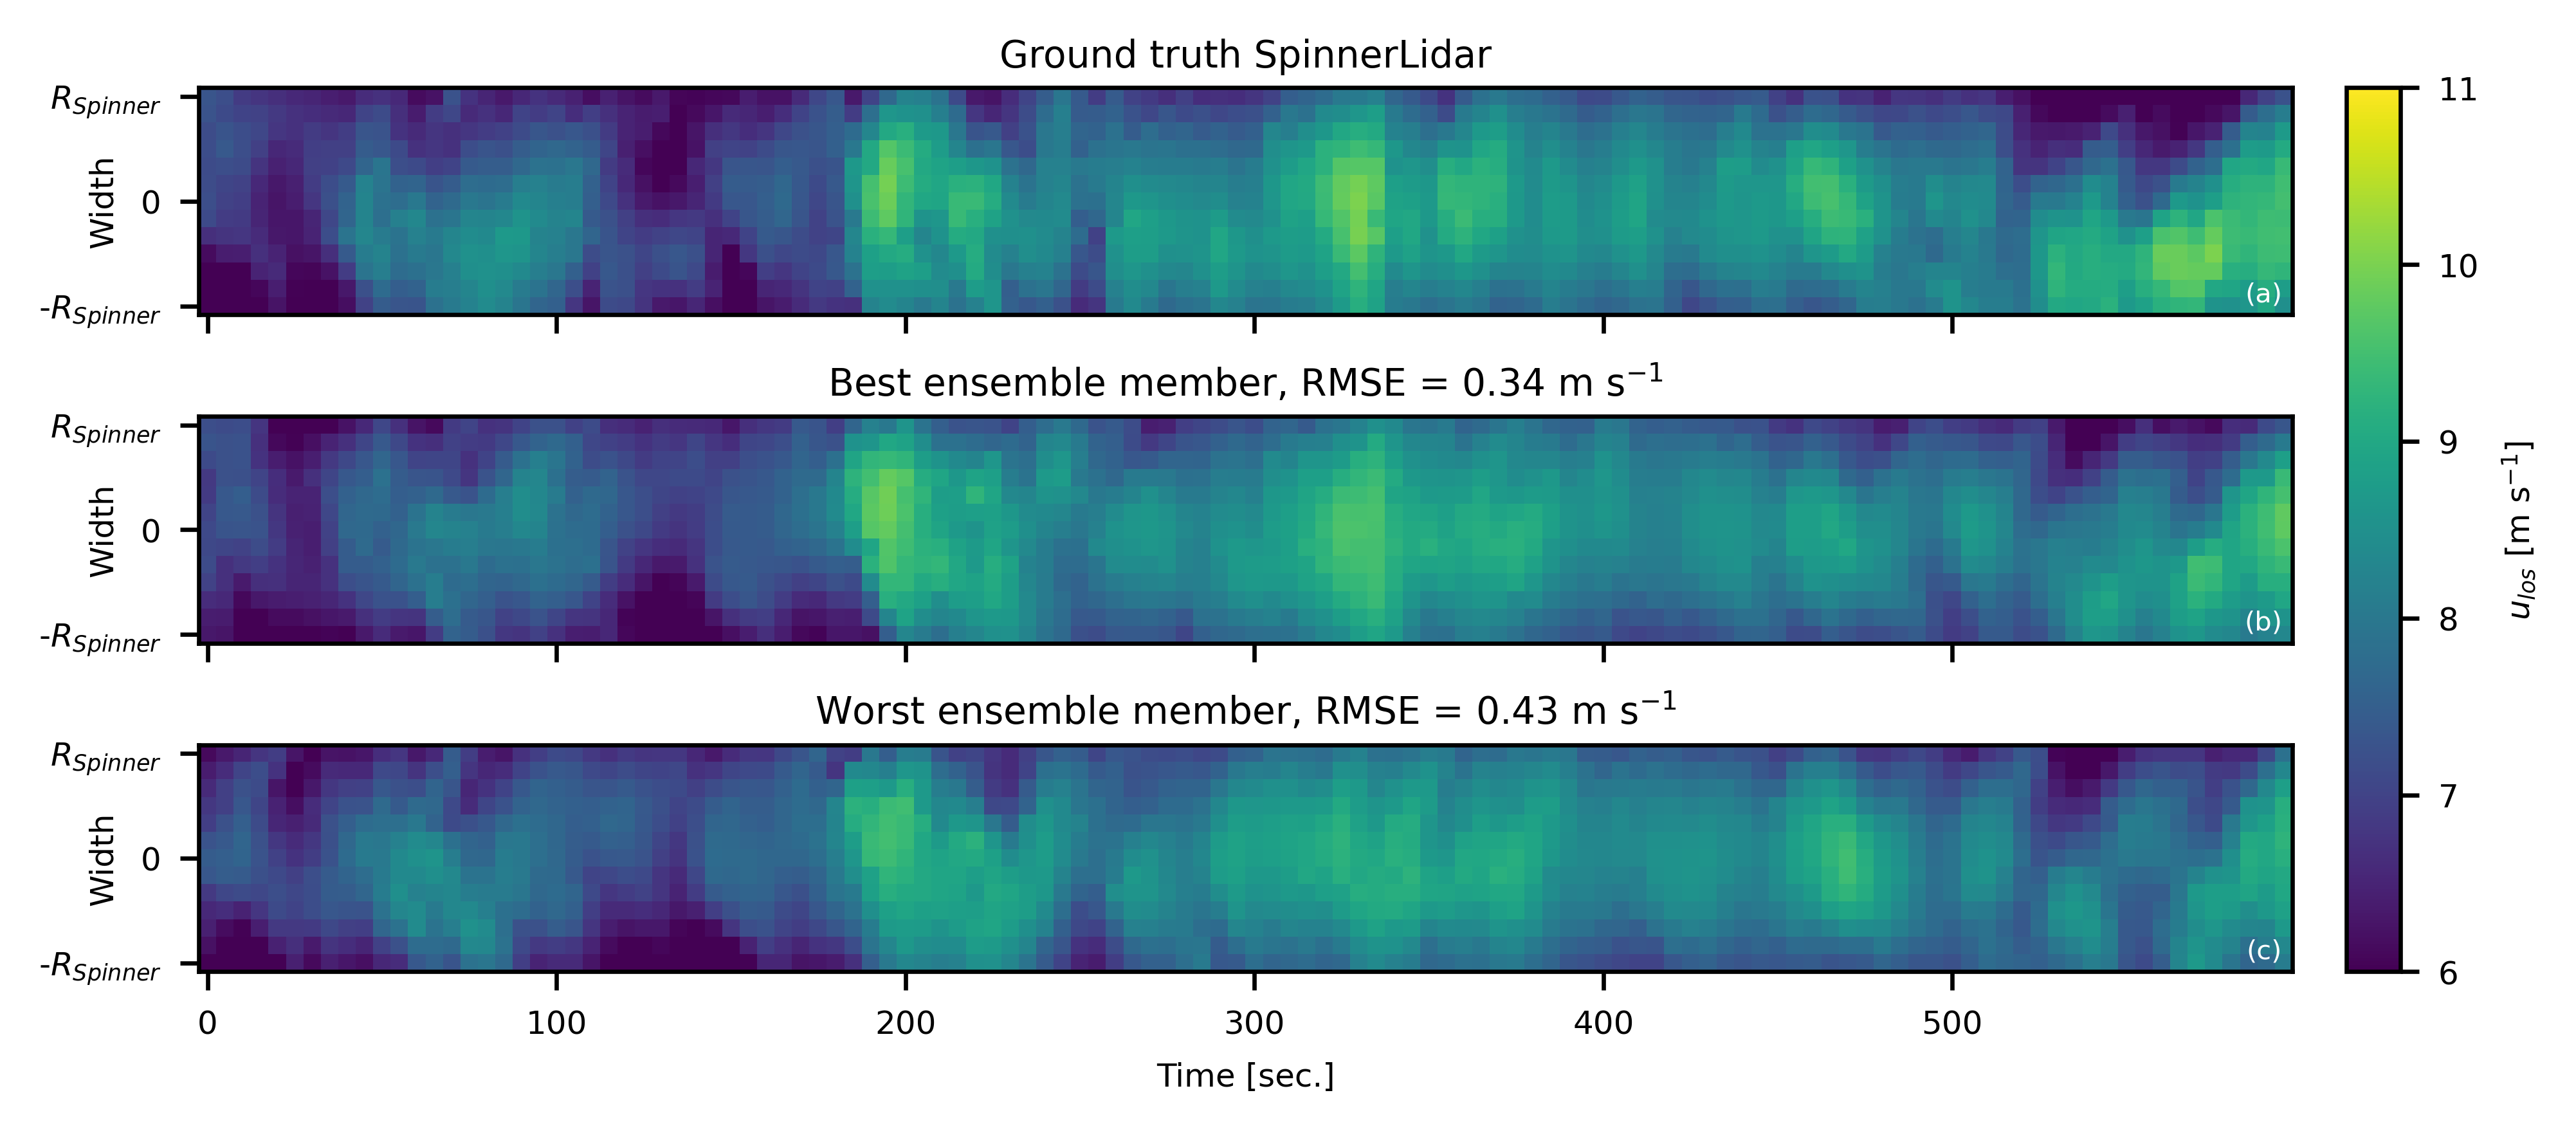

In [5]:
### Top-down view
fig, ax = plt.subplots(3, 1, figsize=(7,3), dpi=600, sharex=True)

plt.subplots_adjust(hspace=0.4)

case_id = 'OSSE2 Period'
ds_halo = ds_halo2
ds_gt = ds_gt2
ds_mod = ds_mod2


## Plot
pltvar = 'vlos'
pltmin, pltmax = 6, 11
yplt = ds_gt['y'].values[1:14]
zplt = 0

# Calculate best/worst ensemble member
rmse_ens_plt = np.mean((ds_mod[pltvar] - ds_gt[pltvar])**2, axis=(1,2,3)).values
iens_best = np.argmin(rmse_ens_plt)
iens_worst = np.argmax(rmse_ens_plt)

data0 = ds_gt[pltvar].sel(y=yplt,z=zplt).values.T
data1 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_best).values.T
data2 = ds_mod[pltvar].sel(y=yplt,z=zplt).isel(ens=iens_worst).values.T

im0 = ax[0].imshow(data0.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im1 = ax[1].imshow(data1.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)
im2 = ax[2].imshow(data2.T,
                   origin='lower',
                   vmin=pltmin,
                   vmax=pltmax)


## Decorate
ax[0].set_title("Ground truth SpinnerLidar",fontsize=7,y=0.95)
ax[1].set_title(f"Best ensemble member, RMSE = {rmse_ens_plt[iens_best]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[2].set_title(f"Worst ensemble member, RMSE = {rmse_ens_plt[iens_worst]:.2f} m s"+"$^{-1}$",fontsize=7,y=0.95)
ax[-1].set_xlabel("Time [sec.]",fontsize=6)

for axs in ax:
    yticks = np.array((0, 6, 12))
    axs.set_yticks(yticks)
    axs.set_yticklabels(['-$R_{Spinner}$', '0', '$R_{Spinner}$'])
    axs.set_ylabel("Width",fontsize=6,labelpad=-15)
    axs.tick_params('both',labelsize=6)
xticks = np.arange(0,120,20)
ax[-1].set_xticks(xticks)
ax[-1].set_xticklabels(5*xticks)

## Colorbar
cax1 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.set_label('$u_{los}$ [m s$^{-1}$]', fontsize=6)
cbar1.ax.tick_params(labelsize=6)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.059,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='white')
    
# plt.savefig('figs/osse_spinner_qualitative_topdown_view.png', bbox_inches='tight', dpi=600)
# plt.savefig('figs/osse_spinner_qualitative_topdown_view_osse2.png', bbox_inches='tight', dpi=600)
    
plt.show()

Number of obs spanned for z=60, case=1: 65.83%
	Mean difference between the max and min ensemble wind speeds: 1.32 m/s
Number of obs spanned for z=60, case=2: 54.17%
	Mean difference between the max and min ensemble wind speeds: 1.23 m/s
Number of obs spanned for z=60, case=3: 55.00%
	Mean difference between the max and min ensemble wind speeds: 1.38 m/s
Number of obs spanned for z=0, case=1: 73.33%
	Mean difference between the max and min ensemble wind speeds: 1.05 m/s
Number of obs spanned for z=0, case=2: 80.83%
	Mean difference between the max and min ensemble wind speeds: 0.95 m/s
Number of obs spanned for z=0, case=3: 65.83%
	Mean difference between the max and min ensemble wind speeds: 1.09 m/s
Number of obs spanned for z=-60, case=1: 85.83%
	Mean difference between the max and min ensemble wind speeds: 1.39 m/s
Number of obs spanned for z=-60, case=2: 74.17%
	Mean difference between the max and min ensemble wind speeds: 1.28 m/s
Number of obs spanned for z=-60, case=3: 75.00%
	

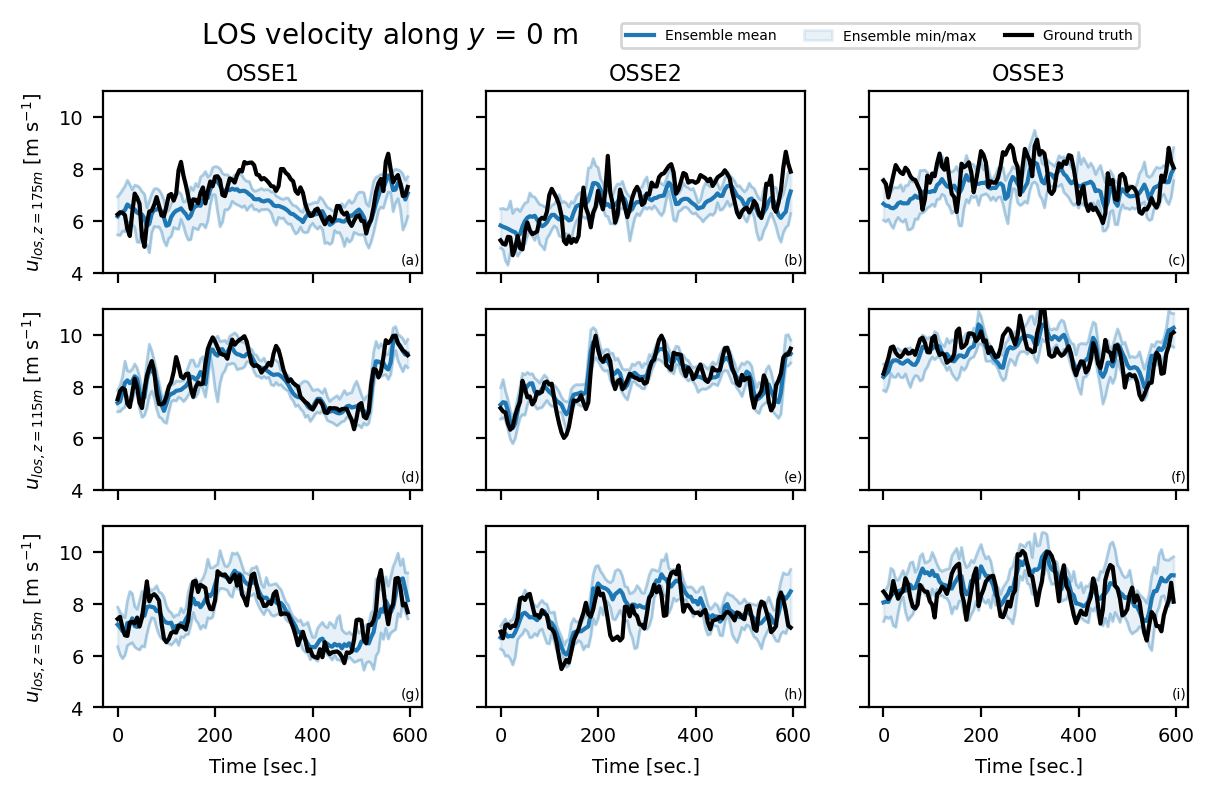

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(7,4), dpi=200, sharey=True, sharex=True)

pltvar = 'vlos'

ds_gt = ds_gt1
ds_mod = ds_mod1

t_plt = (ds_gt['time'].values-ds_gt['time'].values[0]).astype('timedelta64[s]').astype(int)

tot_num_obs_spanned = 0

for irow, zplt in enumerate([60, 0, -60]):
    for icol, ds_gt, ds_mod in zip([0,1,2], [ds_gt1,ds_gt2,ds_gt3], [ds_mod1,ds_mod2,ds_mod3]):
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).mean('ens'),
                         color='C0',
                         label='Ensemble mean')
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).max('ens'),
                         color='C0',
                         alpha=0.3,
                         linewidth=1)
        ax[irow,icol].plot(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).min('ens'),
                         color='C0',
                         alpha=0.3,
                         linewidth=1)
        ax[irow,icol].fill_between(t_plt,
                         ds_mod[pltvar].sel(z=zplt,y=0).min('ens'),
                         ds_mod[pltvar].sel(z=zplt,y=0).max('ens'),
                         color='C0',
                         alpha=0.1,
                         label='Ensemble min/max')
        num_obs_spanned = ((ds_gt[pltvar].sel(z=zplt,y=0) < ds_mod[pltvar].sel(z=zplt,y=0).max('ens')) & (ds_gt[pltvar].sel(z=zplt,y=0) > ds_mod[pltvar].sel(z=zplt,y=0).min('ens'))).sum().values
        pct_obs_spanned = 100 * num_obs_spanned / len(ds_mod['time'])
        print(f"Number of obs spanned for z={zplt}, case={icol+1}: {pct_obs_spanned:.2f}%")
        max_min_diff = (ds_mod[pltvar].sel(z=zplt,y=0).max('ens') - ds_mod[pltvar].sel(z=zplt,y=0).min('ens')).mean().values
        print(f"\tMean difference between the max and min ensemble wind speeds: {max_min_diff:.2f} m/s")

        ax[irow,icol].plot(t_plt,
                         ds_gt[pltvar].sel(z=zplt,y=0),
                         color='k',
                         label='Ground truth')


for axs in ax.flatten():
    axs.tick_params('both',labelsize=8)
    
# for axs in ax[:,0]:
ax[0,0].set_ylabel("$u_{los, z=175 m}$ [m s$^{-1}$]", fontsize=7)
ax[1,0].set_ylabel("$u_{los, z=115 m}$ [m s$^{-1}$]", fontsize=7)
ax[2,0].set_ylabel("$u_{los, z=55 m}$ [m s$^{-1}$]", fontsize=7)
ax[0,0].set_title("OSSE1", fontsize=8, y=0.97)
ax[0,1].set_title("OSSE2", fontsize=8, y=0.97)
ax[0,2].set_title("OSSE3", fontsize=8, y=0.97)
    
for axs in ax.flatten():
    axs.tick_params('both',labelsize=7)
    
for axs in ax[-1,:]:
    axs.set_xlabel("Time [sec.]", fontsize=7)

plt.suptitle("LOS velocity along $y$ = 0 m", fontsize=10, y=0.97, x=0.33)
    
# ax[-1].set_xlabel("Time [UTC]", fontsize=8)
# myFmt = mdates.DateFormatter('%H%M')
# ax[-1].xaxis.set_major_formatter(myFmt)
    
# ax[0].set_title("-60 m", fontsize=7, y=0.95)
# ax[1].set_title("0 m", fontsize=7, y=0.95)
# ax[2].set_title("60 m", fontsize=7, y=0.95)
# plt.subplots_adjust(hspace=0.3)

handles, labels = ax[0,1].get_legend_handles_labels()
lgd = ax[0,1].legend(handles, labels, bbox_to_anchor=(0.4, 1.20), loc='lower left', fontsize=5, ncol=3)

## Subpanel labels
for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.995,
          0.05,
          f'({letter})',
          fontsize=5,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')

ax[0,0].set_ylim(4, 11)
# ax[0,0].set_xlim(0, 200)

    
# plt.savefig('figs/spinner_osse_timeseries_centerline.pdf', bbox_inches='tight')
        
plt.show()

# Profiles of correlation, 1st order stats, and 2nd order stats

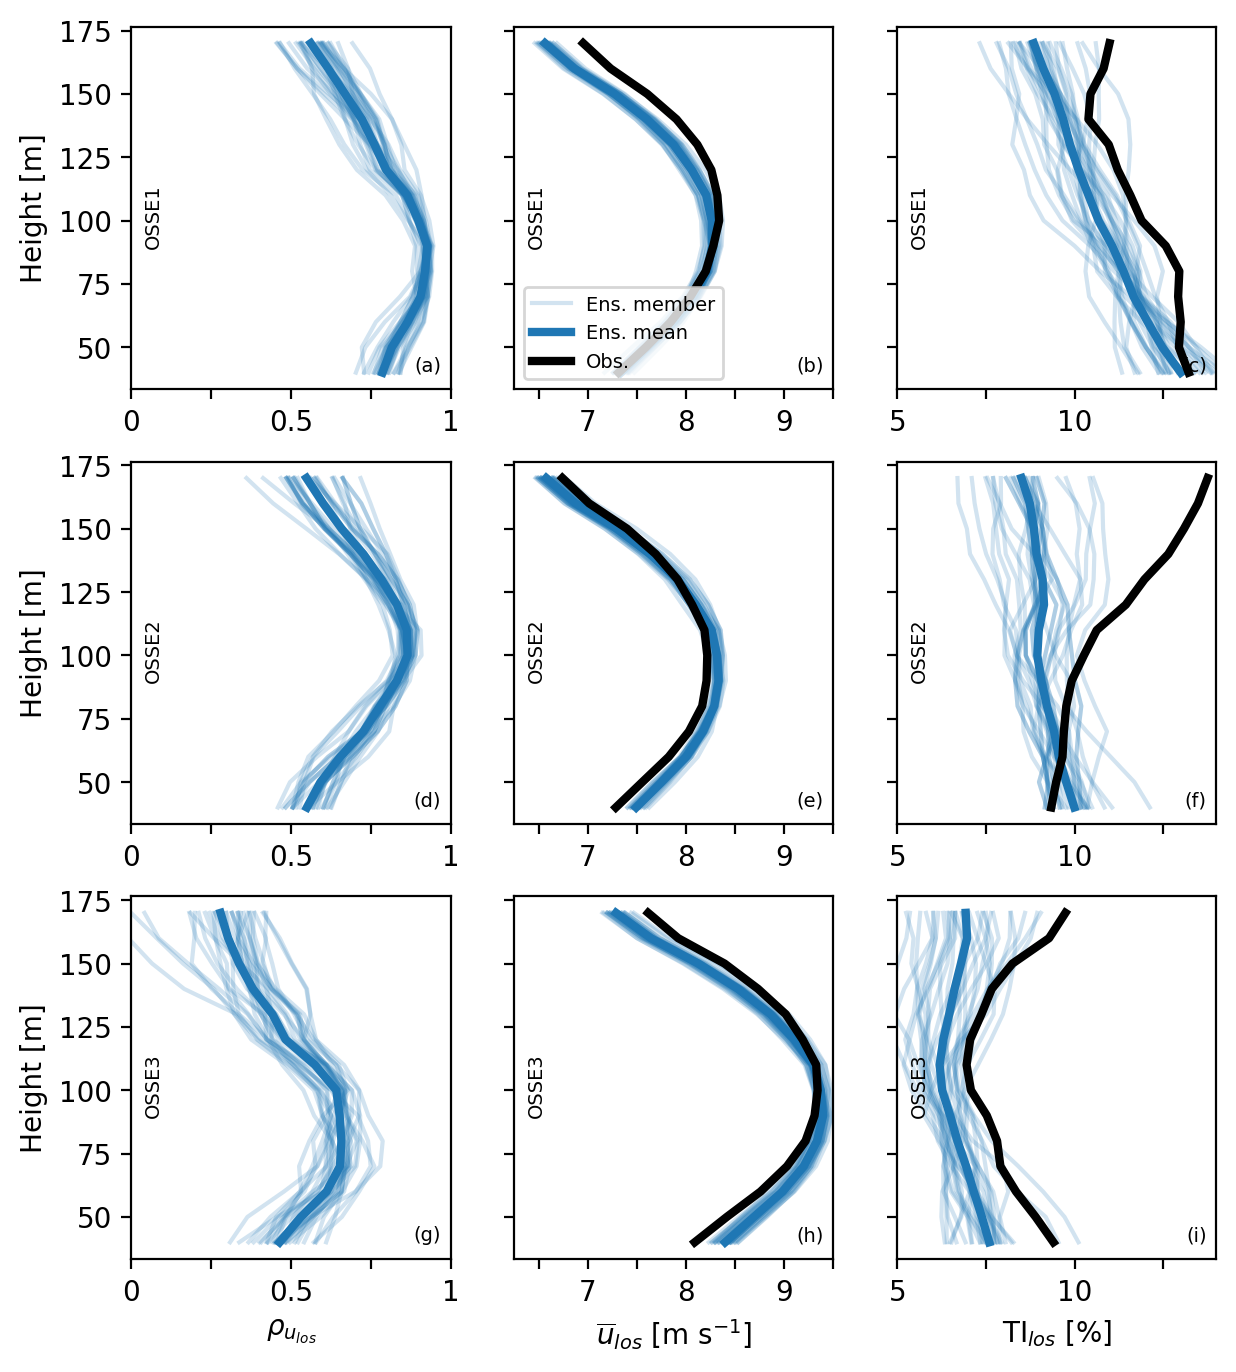

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(7,8), dpi=200, sharey=True)

for axs in ax[:,0]:
    axs.set_ylabel("Height [m]")

ax[-1,0].set_xlabel('$\\rho_{u_{los}}$')
ax[-1,1].set_xlabel('$\overline{u}_{los}$ [m s$^{-1}$]')
# ax[-1,2].set_xlabel('$\sigma_{{u}_{los}}$ [m s$^{-1}$]')
ax[-1,2].set_xlabel('TI$_{los}$ [%]')

# ax[0,0].set_ylim(-80,70)
for axs in ax[:,0]:
    axs.set_xlim(0,1)
for axs in ax[:,1]:
    axs.set_xlim(6.25,9.5)
for axs in ax[:,2]:
    axs.set_xlim(5,14)

for irow, ds_gt, ds_mod in zip([0,1,2], [ds_gt1,ds_gt2,ds_gt3], [ds_mod1,ds_mod2,ds_mod3]):
    corr_y = 0
    corr_profile = np.zeros((len(ds_mod['z']), len(ds_mod['ens'])))
    for k, z in enumerate(ds_mod['z']):
        corr_profile[k,:] = xr.corr(ds_gt['vlos'].sel(y=corr_y,z=z), ds_mod['vlos'].sel(y=corr_y,z=z), dim='time').values[:].copy()
    
    ax[irow,0].plot(corr_profile,
               ds_gt['z']+110,
               color='C0',
               alpha=0.2)
    ax[irow,0].plot(corr_profile.mean(axis=1),
               ds_gt['z']+110,
               color='C0',
               linewidth=3)
    
    for iens in range(30):
        if iens == 0:
            ax[irow,1].plot(ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                       ds_mod['z']+110,
                       color='C0',
                       alpha=0.2,
                       label='Ens. member')
        else:
            ax[irow,1].plot(ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                       ds_mod['z']+110,
                       color='C0',
                       alpha=0.2)
    ax[irow,1].plot(ds_mod['vlos'].sel(y=0).mean(('time', 'ens')),
               ds_mod['z']+110,
               color='C0',
               linewidth=3,
               label='Ens. mean')
    ax[irow,1].plot(ds_gt['vlos'].sel(y=0).mean(('time')),
               ds_gt['z']+110,
               color='k',
               linewidth=3,
               label='Obs.')

    # # Standard deviation
    # for iens in range(30):
    #     ax[irow,2].plot(ds_mod['vlos'].sel(ens=iens,y=0).std('time'),
    #                ds_mod['z']+110,
    #                color='C0',
    #                alpha=0.2)
    # ax[irow,2].plot(ds_mod['vlos'].sel(y=0).std('time').mean('ens'),
    #            ds_mod['z']+110,
    #            color='C0',
    #            linewidth=3)
    # ax[irow,2].plot(ds_real['vlos'].sel(y=0).std(('time')),
    #            ds_real['z']+110,
    #            color='k',
    #            linewidth=3)
    
    # TI
    for iens in range(30):
        ax[irow,2].plot(100*ds_mod['vlos'].sel(ens=iens,y=0).std('time')/ds_mod['vlos'].sel(ens=iens,y=0).mean('time'),
                   ds_mod['z']+110,
                   color='C0',
                   alpha=0.2)
    ax[irow,2].plot(100*(ds_mod['vlos'].sel(y=0).std('time')/ds_mod['vlos'].sel(y=0).mean('time')).mean('ens'),
               ds_mod['z']+110,
               color='C0',
               linewidth=3)
    ax[irow,2].plot(100*ds_gt['vlos'].sel(y=0).std(('time'))/ds_gt['vlos'].sel(y=0).mean(('time')),
               ds_gt['z']+110,
               color='k',
               linewidth=3)

# ax[0].set_xlim(-0.5, 1.0)
# ax[2].set_xlim(0, 0.8)

for axs, letter in zip(ax.flatten(), list(string.ascii_lowercase)):
    axs.text(0.97,
          0.05,
          f'({letter})',
          fontsize=7,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='k')
    
for axs in ax[0,:]:
    axs.text(0.1,
             0.4,
             'OSSE1',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
for axs in ax[1,:]:
    axs.text(0.1,
             0.4,
             'OSSE2',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
for axs in ax[2,:]:
    axs.text(0.1,
             0.4,
             'OSSE3',
             fontsize=7,
             transform = axs.transAxes,
             horizontalalignment='right',
             color='k',
             rotation=90)
    
ax[0,1].legend(fontsize=7,
              loc='lower left')
    

ax[0,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[1,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[2,0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[0,0].set_xticklabels([0, None, 0.5, None, 1])
ax[1,0].set_xticklabels([0, None, 0.5, None, 1])
ax[2,0].set_xticklabels([0, None, 0.5, None, 1])

ax[0,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[1,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[2,1].set_xticks([6.5, 7, 7.5, 8, 8.5, 9, 9.5])
ax[0,1].set_xticklabels([None, 7, None, 8, None, 9, None])
ax[1,1].set_xticklabels([None, 7, None, 8, None, 9, None])
ax[2,1].set_xticklabels([None, 7, None, 8, None, 9, None])

ax[0,2].set_xticks([5, 7.5, 10, 12.5])
ax[1,2].set_xticks([5, 7.5, 10, 12.5])
ax[2,2].set_xticks([5, 7.5, 10, 12.5])
ax[0,2].set_xticklabels([5, None, 10, None])
ax[1,2].set_xticklabels([5, None, 10, None])
ax[2,2].set_xticklabels([5, None, 10, None])

    
# plt.savefig('figs/osse_spinner_profile_validation.pdf')

plt.show()

# Pixel-by-pixel error histogram

1500 mean error = -0.08 m/s, std dev = 0.59 m/s
1530 mean error = 0.01 m/s, std dev = 0.62 m/s
1600 mean error = 0.00 m/s, std dev = 0.68 m/s


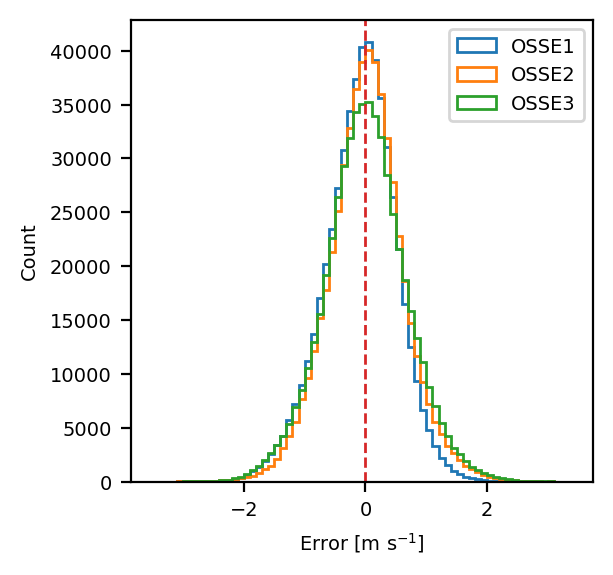

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3), dpi=200, sharey=True)

ax.set_box_aspect(1)
# axs.set_yticks([])
# axs.set_yticklabels([])
    
bins_err = np.arange(-3.5, 3.5, 0.1)

err1 = (ds_mod1['vlos'] - ds_gt1['vlos']).values.flatten()
err2 = (ds_mod2['vlos'] - ds_gt2['vlos']).values.flatten()
err3 = (ds_mod3['vlos'] - ds_gt3['vlos']).values.flatten()
ax.hist(err1, bins=bins_err, edgecolor='C0', facecolor='none', label='OSSE1', histtype='step')
ax.hist(err2, bins=bins_err, edgecolor='C1', facecolor='none', label='OSSE2', histtype='step')
ax.hist(err3, bins=bins_err, edgecolor='C2', facecolor='none', label='OSSE3', histtype='step')
ax.axvline(0, color='C3', ls='--', linewidth=1)
ax.set_xlabel("Error [m s$^{-1}$]", fontsize=7)
ax.tick_params('both',labelsize=7)

ax.set_ylabel("Count", fontsize=7)
ax.legend(fontsize=7)

# plt.savefig('figs/spinner_osse_histogram.pdf', bbox_inches='tight')

print(f"OSSE1 mean error = {np.nanmean(err1):.2f} m/s, std dev = {np.nanstd(err1):.2f} m/s")
print(f"OSSE2 mean error = {np.nanmean(err2):.2f} m/s, std dev = {np.nanstd(err2):.2f} m/s")
print(f"OSSE3 mean error = {np.nanmean(err3):.2f} m/s, std dev = {np.nanstd(err3):.2f} m/s")
    
plt.show()